In [2]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

In [3]:
def Euclidean_Distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [4]:
def K_Means(data, k, max_iter=100):
    if k <= 1 or (len(data) < k):
        return

    # choose cluster centroids randomly
    centroids = data[np.random.choice(data.shape[0], k)]
    
    for i in range(max_iter):
        
        # Calculate the Euclidean distance between each data point and each centroid
        distances = []
        for x in data:
            row = []
            for c in centroids:
                row.append(Euclidean_Distance(x, c))
            distances.append(row)
        distances = np.array(distances)
  
        # assign data points to the closest cluster
        labels = np.argmin(distances, axis=1)

        # update cluster centroids
        new_centroids = []
        for j in range(k):
            data_points = data[labels == j]
            mean = data_points.mean(axis=0)
            new_centroids.append(mean)
        new_centroids = np.array(new_centroids)

        # check if converges
        if np.allclose(new_centroids, centroids):
              break

        centroids = new_centroids

    return centroids, labels

In [5]:
def simple_visualize(X, labels, centroids):
    # Create a scatter plot of the data points
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=50)

    # Mark the centroids with a star
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c="red", s=200)

    # Show the plot
    plt.show()

In [6]:
def E_step(data, mu, cov, pi):
    num_clusters = mu.shape[0]
    r = np.zeros((data.shape[0], num_clusters))
    
    # Estimate the probabilities that each data point belongs to each cluster
    for k in range(num_clusters):
        mu_k = mu[k, :]
        cov_k = cov[k, :, :]
        pi_k = pi[k]
        r[:, k] = pi_k * multivariate_normal.pdf(data, mu_k, cov_k, allow_singular=True)
        
    # Since the old pi is fixed, so we can calculate the numerators first and then divide 
    # Similar to the softmax function    
    r /= r.sum(axis=1, keepdims=True)
    
    return r

def M_step(data, r):
    num_clusters = r.shape[1]
    n, dims = data.shape
    
    mu = np.zeros((num_clusters, dims))
    cov = np.zeros((num_clusters, dims, dims))
    pi = np.zeros(num_clusters)
    
    # Update pi 
    N_k = np.sum(r, axis=0)
    pi = N_k / n
    for k in range(num_clusters):
        # Update mu
        mu[k, :] = (r[:, k].dot(data)) / N_k[k]

        # Update sigma (cov)
        # Note that the shape of the covariance matrix for cluster k should be m x m 
        # Note that a small epsilon residue is added to cov_k is guarantee PSD        
        centered_data = data - mu[k, :]
        weighted_cov_i = np.array([r[i][k] * centered_data[i,:] for i in range(n)]) 
        weighted_cov_sum = np.matmul(weighted_cov_i.T, centered_data)
        cov[k, :, :] = (weighted_cov_sum / N_k[k]) + (1e-7) * np.eye(dims)
        
    return mu, cov, pi


def GMM_EM(data, num_clusters, max_iter=100, tol=1e-5):
    # Initialize the model parameters
    n, dims = np.shape(data)
    mu = np.random.rand(num_clusters, dims)
    cov = np.zeros((num_clusters, dims, dims))
    r = np.zeros((n, num_clusters))
    for i in range(num_clusters):
        cov[i, :, :] = np.eye(dims)
    pi = np.ones(num_clusters) / num_clusters
    
    log_likelihood = None
    
    for count in range(max_iter):
        # E-Step: update posterior probability
        r = E_step(data, mu, cov, pi)
        # M-Step: update model parameters
        mu, cov, pi = M_step(data, r)
        
        # Compute the log-likelihood
        log_likelihood_new = 0
        for k in range(num_clusters):
            mu_k = mu[k, :]
            cov_k = cov[k, :, :]
            pi_k = pi[k]
            log_likelihood_new += pi_k * multivariate_normal(mu_k, cov_k, allow_singular=True).pdf(data)

        
        # Sum of n samples' log likehood
        log_likelihood_new = np.log(log_likelihood_new).sum()

        # Check for convergence
        if log_likelihood is not None and abs(log_likelihood_new - log_likelihood) < tol:
            break
        else:
            log_likelihood = log_likelihood_new

    # Return the predicted labels
    return np.argmax(r, axis=1)

In [7]:
def silhouette_coefficient(X, labels):
    # Calculate pairwise distances between samples
    distances = pairwise_distances(X)

    # Calculate the silhouette coefficient for each sample
    sc = []

    for i in range(len(X)):
        # Get the label for the current sample
        cluster = labels[i]

        outer_dist = dict()
        dist_counter = dict()
        for c in set(labels):
            outer_dist[c] = 0
            dist_counter[c] = 0

        # Calculate the average distance to all other samples in the same cluster
        intra_distance = []
        for j in range(len(X)):
            if labels[j] == cluster:
                intra_distance.append(distances[i, j])
            else:
                outer_dist[labels[j]] += distances[i, j]
                dist_counter[labels[j]] += 1
        a = np.mean(intra_distance)
        
        # Calculate the average distance to the nearest cluster
        mean_cluster_distance = []
        if len(set(labels)) == 1:
            b = 0
        else: 
            for key, values in outer_dist.items():
                if key != cluster:
                    mean_cluster_distance.append(values / dist_counter[key])
            try: 
                b = np.amin(mean_cluster_distance)
            except:
                print("Unexpected fault:")
                print("labels: ", labels)
                print("mean_outer_cluster_distance: ", mean_cluster_distance)
                b = 0

        silhouette_coefficient = (b - a) / max(a, b)
        sc.append(silhouette_coefficient)
        
    return np.mean(sc)

In [8]:
def rand_index(labels_true, labels_pred):
    # Compute the number of pairs of points
    num_pairs = labels_true.shape[0] * (labels_true.shape[0] - 1) // 2
    
    # Compute the number of pairs of points that are in the same cluster in both the true and predicted labels
    pairs = 0
    for i in range(labels_true.shape[0]):
        for j in range(i+1, labels_true.shape[0]):
            if labels_true[i] == labels_true[j] and labels_pred[i] == labels_pred[j]:
                pairs += 1
            elif labels_true[i] != labels_true[j] and labels_pred[i] != labels_pred[j]:
                pairs += 1
    
    # Compute the rand index
    return pairs / num_pairs

In [9]:
# Data preparation

data = np.loadtxt("./seeds_dataset.txt", dtype=float)
X_train, gt_label = np.split(data, [7], axis=1)

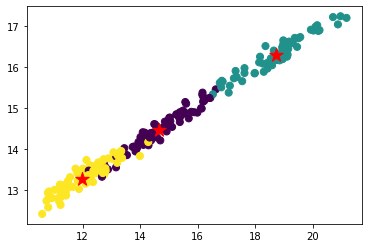

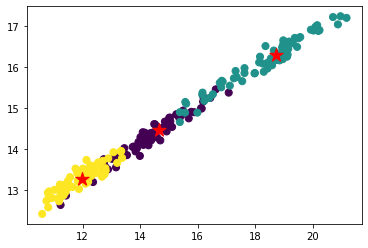

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2]


In [10]:
# K-Means with k=3

km_centroids, km_labels = K_Means(X_train, 3)
simple_visualize(X_train, km_labels, km_centroids)
simple_visualize(X_train, gt_label, km_centroids)
# print(centroids)
print(km_labels)
# print(gt_label)

In [20]:
# EM-GMM with k=3

em_labels = GMM_EM(X_train, 3)
# print(gt_label)
print(em_labels)

[0 0 0 0 2 0 0 0 2 2 0 0 0 0 0 0 0 2 0 1 0 0 2 1 0 2 0 0 0 0 0 0 0 0 0 2 2
 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 0 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1]


In [21]:
# Performance Evaluation
# from sklearn.metrics import silhouette_score
# score = silhouette_score(X_train, em_labels)
# print(score)


print("Silhouette Coefficient for K-Means: ",silhouette_coefficient(X_train, km_labels))
print("Silhouette Coefficient for EM-GMM: ",silhouette_coefficient(X_train, em_labels))

Silhouette Coefficient for K-Means:  0.47943599429227524
Silhouette Coefficient for EM-GMM:  0.4243984873123935


In [22]:
print("Rand Index for K-Means: ", rand_index(km_labels, gt_label))
print("Rand Index for EM-GMM: ", rand_index(em_labels, gt_label))

Rand Index for K-Means:  0.8743677375256322
Rand Index for EM-GMM:  0.8708133971291866


In [23]:
# Sensitivity analysis

import warnings
warnings.filterwarnings('ignore')


km_silh = []
km_rand = []
em_silh = []
em_rand = []
for i in range (100):
    em_labels = GMM_EM(X_train, 3)
    km_centroids, km_labels = K_Means(X_train, 3)
    km_silh.append(silhouette_coefficient(X_train, km_labels))
    km_rand.append(rand_index(km_labels, gt_label))
    em_silh.append(silhouette_coefficient(X_train, em_labels))
    em_rand.append(rand_index(em_labels, gt_label))
    
km_silh_std = np.std(km_silh)
km_rand_std = np.std(km_rand)
em_silh_std = np.std(em_silh)
em_rand_std = np.std(em_rand)

km_silh_avg = np.mean(km_silh)
km_rand_avg = np.mean(km_rand)
em_silh_avg = np.mean(em_silh)
em_rand_avg = np.mean(em_rand)

print("Trying 100 times")
print("Sensitivity of K-Means to random initialization:")
print("std_1(silhouette_coeff) =", km_silh_std, "std_2(rand_idx) =", km_rand_std)
print("\nSensitivity of GMM-EM to random initialization.")
print("std_1(silhouette_coeff) =", em_silh_std, "std_2(rand_idx) =", em_rand_std)

print("\nAverage performance score:")
print("K-Means: silhouette_coeff =", km_silh_avg, "rand_idx =", km_rand_avg)
print("GMM-EM: silhouette_coeff =", em_silh_avg, "rand_idx =", em_rand_avg)

Trying 100 times
Sensitivity of K-Means to random initialization:
std_1(silhouette_coeff) = 0.1470300732021276 std_2(rand_idx) = 0.054022234889743205

Sensitivity of GMM-EM to random initialization.
std_1(silhouette_coeff) = 0.14005353473730722 std_2(rand_idx) = 0.13567693529792876

Average performance score:
K-Means: silhouette_coeff = 0.4628142977263458 rand_idx = 0.8674518113465481
GMM-EM: silhouette_coeff = 0.2719704191917034 rand_idx = 0.7445340624287994
